In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

In [3]:
news_outlets = pd.read_csv("APRIL2019_DATABASE_State of the Latino News Media - MARCH2019_FINAL_MASTER_DATABASE.csv")
news_outlets.head()

,Estado,State,Medio,Media Outlet,Ciudad,City,Dirección,Zip Code,Latitud,Longitud,...,Fuentes de ingresos,Sources of Revenue,Número de empleados/Number of employees,Frecuencia,Frequency,Facebook,Twitter,Instagram,YouTube,Otra red social
0,Alabama,Alabama,Latino News,Latino News,Trussville,Trussville,PO Box 1313,35173,33.637321,-86.560208,...,NaN,NaN,NaN,Semanario,Weekly,https://www.facebook.com/LatinoNewspaper/,https://twitter.com/latinonews1,NaN,NaN,NaN
1,Alabama,Alabama,Alabama TV,Alabama TV,Hoover,Hoover,"2105 Lorna Ridge Lane, Suite 151",35216,33.391113,-86.796007,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/alabamatv/,https://twitter.com/AlabamaTv,https://www.instagram.com/alabamatv/,https://www.youtube.com/channel/UCdXIk0_d5kv_p...,NaN
2,Alabama,Alabama,Líder News,Líder News,Birmingham,Birmingham,PO Box 360535,35236,33.370188,-86.809721,...,Publicidad,Advertising,6-10,Semanal,Weekly,https://www.facebook.com/lidernews.alabama/,NaN,NaN,NaN,NaN
3,Alaska,Alaska,KDMD Telemundo Alaska,KDMD Telemundo Alaska,Anchorage,Anchorage,1310 E. 66th Ave.,99518,61.161005,-149.857320,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/Telemundo-Alaska-1662...,https://twitter.com/telemundoalaska,NaN,NaN,NaN
4,Alaska,Alaska,Sol de Medianoche,Sol de Medianoche,Anchorage,Anchorage,PO Box 93466,99501,61.233689,-149.851780,...,Publicidad,Advertising,1-5,Diario,Daily,https://www.facebook.com/soldemedianochenews/,NaN,NaN,NaN,NaN


In [4]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [5]:
name_fb = news_outlets[['State','Facebook']].copy()
name_fb = name_fb[name_fb['Facebook'].notna()]

In [6]:
name_fb['clean_url'] = name_fb['Facebook'].apply(clean_address)
name_fb

,State,Facebook,clean_url
0,Alabama,https://www.facebook.com/LatinoNewspaper/,latinonewspaper
1,Alabama,https://www.facebook.com/alabamatv/,alabamatv
2,Alabama,https://www.facebook.com/lidernews.alabama/,lidernews.alabama
3,Alaska,https://www.facebook.com/Telemundo-Alaska-1662...,telemundo-alaska-166204037463565
4,Alaska,https://www.facebook.com/soldemedianochenews/,soldemedianochenews
...,...,...,...
619,Wisconsin,https://www.facebook.com/ElConquistadorNews/,elconquistadornews
620,Wisconsin,https://www.facebook.com/spanishjournal,spanishjournal
621,Wisconsin,https://www.facebook.com/TelemundoWisconsin,telemundowisconsin
622,Wisconsin,https://www.facebook.com/AztecaWisconsin/,aztecawisconsin


In [7]:
democrat = pd.read_csv("Biden_Posts.csv")
democrat.head(5)

,Page Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,Mundo Hispánico,mundohispanico,279933092023507,4576200.0,2020-09-13 13:00:44 EDT,Photo,2163,2849,192,285,...,TODOS CONTRA TRUMP. Con tal de 'sacar' al pres...,https://www.facebook.com/mundohispanico/photos...,https://www.facebook.com/login/?next=https%3A%...,UNITED to 3033 ADEN,NaN,NaN,NaN,NaN,"5,659","5,659"
1,El Nuevo Día,elnuevodia,5996048750,2248500.0,2020-09-30 09:50:41 EDT,Link,1049,1894,585,88,...,Opinión El Nuevo Día | Si es relecto como pres...,https://www.elnuevodia.com/opinion/punto-de-vi...,NaN,NaN,A Joe Biden no le importan los puertorriqueños,NaN,NaN,NaN,"5,642","5,642"
2,Mundo Hispánico,mundohispanico,279933092023507,4591841.0,2020-10-07 21:31:18 EDT,Photo,1687,2667,154,261,...,EN SU PROPIA CARA. A minutos de comenzar el DE...,https://www.facebook.com/mundohispanico/photos...,NaN,MUNDO KISPANICO ÚLTIMA HORA,NaN,NaN,NaN,NaN,"5,064","5,064"
3,Mundo Hispánico,mundohispanico,279933092023507,4569864.0,2020-08-20 21:47:55 EDT,Photo,798,3166,155,34,...,NaN,https://www.facebook.com/MarioGuevaraNews/phot...,https://www.facebook.com/login/?next=https%3A%...,ΜΗ ÚLTIMA HORA,Mario Guevara,¡EN SU PROPIA CASA! A minutos de que BIDEN ace...,NaN,NaN,"4,695","4,695"
4,El Nuevo Día,elnuevodia,5996048750,2248324.0,2020-10-16 13:02:02 EDT,Link,2029,1397,183,404,...,Junto a Alex Rodríguez participó de un convers...,https://www.elnuevodia.com/corresponsalias/was...,NaN,NaN,Jenniffer López endosa oficialmente a Joe Biden,NaN,NaN,NaN,"4,573","4,573"


In [8]:
democrat['URL']

0       https://www.facebook.com/mundohispanico/posts/...
1       https://www.facebook.com/elnuevodia/posts/1015...
2       https://www.facebook.com/mundohispanico/posts/...
3       https://www.facebook.com/mundohispanico/posts/...
4       https://www.facebook.com/elnuevodia/posts/1015...
                              ...                        
2962    https://www.facebook.com/UnivisionNuevoMexico/...
2963    https://www.facebook.com/UnivisionNuevoMexico/...
2964    https://www.facebook.com/UnivisionNuevoMexico/...
2965    https://www.facebook.com/UnivisionNuevoMexico/...
2966    https://www.facebook.com/UnivisionNuevoMexico/...
Name: URL, Length: 2967, dtype: object

In [9]:
democrat['clean_url'] = democrat['URL'].apply(clean_address)
democrat['clean_url']

0             mundohispanico
1                 elnuevodia
2             mundohispanico
3             mundohispanico
4                 elnuevodia
                ...         
2962    univisionnuevomexico
2963    univisionnuevomexico
2964    univisionnuevomexico
2965    univisionnuevomexico
2966    univisionnuevomexico
Name: clean_url, Length: 2967, dtype: object

In [10]:
democrat['clean_url'].isna().sum()

0

In [11]:
democrat_st =  democrat.merge(name_fb, on="clean_url", how="left")
democrat_st.loc[democrat_st['Page Name'] == 'El Kentubano','State'] = 'Kentucky'

In [12]:
democrat_st['State']

0           Georgia
1       Puerto Rico
2           Georgia
3           Georgia
4       Puerto Rico
           ...     
3462            NaN
3463            NaN
3464            NaN
3465            NaN
3466            NaN
Name: State, Length: 3467, dtype: object

In [13]:
df = democrat_st['State'].value_counts().reset_index()
df.columns = ['State','Count']
df

,State,Count
0,Nevada,298
1,Arizona,234
2,Colorado,226
3,Pennsylvania,206
4,Florida,198
5,California,193
6,Massachusetts,192
7,Puerto Rico,182
8,New York,154
9,"Washington, D.C.",133


In [14]:
df.to_csv('Democrat.csv',index=False)

In [15]:
democrat.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [16]:
message = democrat[['Message','Description']]
message

,Message,Description
0,TODOS CONTRA TRUMP. Con tal de 'sacar' al pres...,NaN
1,Opinión El Nuevo Día | Si es relecto como pres...,NaN
2,EN SU PROPIA CARA. A minutos de comenzar el DE...,NaN
3,NaN,¡EN SU PROPIA CASA! A minutos de que BIDEN ace...
4,Junto a Alex Rodríguez participó de un convers...,NaN
...,...,...
2962,Joe Biden ya es el candidato oficial demócrata...,NaN
2963,"Ahora #Envivo desde la Convención Demócrata, d...","#EnVivo: Bill Clinton, Jimmy Carter y Jill Bid..."
2964,"#EnVivo: Bill Clinton, Jimmy Carter y Jill Bid...","#EnVivo: Bill Clinton, Jimmy Carter y Jill Bid..."
2965,Segundo día de la Convención Demócrata. Entre ...,Segundo día de la Convención Demócrata. Entre ...


In [17]:
content = message['Message'].fillna('') + (' ' + message['Description']).fillna('')

content = pd.DataFrame(content)
content.columns = ['Message']
content

,Message
0,TODOS CONTRA TRUMP. Con tal de 'sacar' al pres...
1,Opinión El Nuevo Día | Si es relecto como pres...
2,EN SU PROPIA CARA. A minutos de comenzar el DE...
3,¡EN SU PROPIA CASA! A minutos de que BIDEN ac...
4,Junto a Alex Rodríguez participó de un convers...
...,...
2962,Joe Biden ya es el candidato oficial demócrata...
2963,"Ahora #Envivo desde la Convención Demócrata, d..."
2964,"#EnVivo: Bill Clinton, Jimmy Carter y Jill Bid..."
2965,Segundo día de la Convención Demócrata. Entre ...


In [18]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage']

0       TODOS CONTRA TRUMP. Con tal de 'sacar' al pres...
1       Opinión El Nuevo Día | Si es relecto como pres...
2       EN SU PROPIA CARA. A minutos de comenzar el DE...
3        ¡EN SU PROPIA CASA! A minutos de que BIDEN ac...
4       Junto a Alex Rodríguez participó de un convers...
                              ...                        
2962    Joe Biden ya es el candidato oficial demócrata...
2963    Ahora #Envivo desde la Convención Demócrata, d...
2964    #EnVivo: Bill Clinton, Jimmy Carter y Jill Bid...
2965    Segundo día de la Convención Demócrata. Entre ...
2966    "No sólo era mi hermano, era mi mejor amigo”, ...
Name: cleanMessage, Length: 2967, dtype: object

In [40]:
# Convert to list
data = content.cleanMessage.tolist()

In [41]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


## Tokenize words and Clean-up text

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['todos', 'contra', 'trump', 'con', 'tal', 'de', 'sacar', 'al', 'presidente', 'de', 'la', 'casa', 'blanca', 'joe', 'biden', 'recibe', 'inesperada', 'ayuda']]


## Creating Bigram and Trigram Models

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['todos', 'contra', 'trump', 'con', 'tal', 'de', 'sacar', 'al', 'presidente', 'de', 'la', 'casa_blanca', 'joe', 'biden', 'recibe', 'inesperada', 'ayuda']


## Remove Stopwords, Make Bigrams and Lemmatize


In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['trump', 'sacar', 'presidente', 'inesperado', 'ayudar']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


[[('ayudar', 1),
  ('inesperado', 1),
  ('presidente', 1),
  ('sacar', 1),
  ('trump', 1)]]

## Building the Topic Model

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [27]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.310*"trump" + 0.200*"presidente" + 0.042*"discursar" + 0.039*"partir" + '
  '0.038*"ser" + 0.029*"ano" + 0.027*"despues" + 0.024*"ahora" + 0.022*"ganar" '
  '+ 0.019*"casa_blanca"'),
 (1,
  '0.110*"anunciar" + 0.107*"mas" + 0.106*"hacer" + 0.099*"encontrar" + '
  '0.098*"vicepresidencia" + 0.067*"personar" + 0.042*"punto" + '
  '0.038*"criticar" + 0.035*"cambiar" + 0.032*"momento"'),
 (2,
  '0.132*"inmigrante" + 0.095*"gran" + 0.080*"conocer" + 0.062*"esposo" + '
  '0.028*"beneficiar" + 0.025*"reaccionar" + 0.022*"juntar" + 0.017*"poderoso" '
  '+ 0.016*"querer" + 0.015*"pagar"'),
 (3,
  '0.682*"debatir" + 0.142*"ultimar" + 0.017*"propuesta" + 0.008*"mejorar" + '
  '0.007*"presidencial" + 0.002*"siguelo" + 0.000*"jueves" + '
  '0.000*"debates_presidenciales" + 0.000*"http_notiya" + 0.000*"cobertura"'),
 (4,
  '0.242*"votar" + 0.232*"republicano" + 0.101*"primero" + 0.042*"nacional" + '
  '0.034*"indocumentado" + 0.028*"buscar" + 0.017*"revelar" + 0.014*"seran" + '
  '0.013*"m

## Compute Model Perplexity and Coherence Score


In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.164935519754223

Coherence Score:  0.42583568773585795


## Visualize the topics-keywords

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.343832 -0.304243       1        1  20.334452
13     0.253592  0.317050       2        1  11.906234
15     0.076055  0.009717       3        1   7.400890
14     0.072182  0.009147       4        1   6.441777
1      0.027552 -0.000182       5        1   6.344668
5      0.016202 -0.002216       6        1   5.930593
3      0.105255  0.109670       7        1   5.355415
18    -0.008845  0.003705       8        1   4.971288
7     -0.035227 -0.008837       9        1   4.353141
4     -0.031117 -0.008232      10        1   4.206896
10    -0.069371 -0.011895      11        1   3.343692
17    -0.033716 -0.008458      12        1   3.150117
19    -0.053691 -0.010509      13        1   3.089553
11    -0.079548 -0.012638      14        1   3.010449
6     -0.063096 -0.011322      15        1   2.818313
9     -0.097590 -0.013818      16        1   1.835266
16    -0.094222 -0.013628      17        1   1.833004
2     -0.102436 -0.014077      18        1   1.713252
12    -0.108952 -0.014418      19        1   1.155493
8     -0.116860 -0.014815      20        1   0.805506, topic_info=           Term         Freq        Total Category  logprob  loglift
13      debatir  1449.000000  1449.000000  Default  30.0000  30.0000
4         trump  2501.000000  2501.000000  Default  29.0000  29.0000
22    candidato  1511.000000  1511.000000  Default  28.0000  28.0000
68     elección   969.000000   969.000000  Default  27.0000  27.0000
2    presidente  1609.000000  1609.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
824     equipar     0.041029     1.544747  Topic20  -8.9585   1.1931
775     mostrar     0.041031     1.544930  Topic20  -8.9584   1.1930
687        dias     0.041027     1.544778  Topic20  -8.9585   1.1930
573      jueves     0.041029     1.545904  Topic20  -8.9585   1.1924
526       coser     0.041025     1.544532  Topic20  -8.9586   1.1932

[730 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
270       9  0.890943  abandonar
57        3  0.809937   accionar
53       15  0.838608     acepto
120      13  0.987308     actual
225       6  0.835320     acudir
...     ...       ...        ...
261       3  0.994695    votante
30       10  0.997148      votar
224       3  0.865345    votaria
366       3  0.979667        voz
125       8  0.997136         ﻿1

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 14, 16, 15, 2, 6, 4, 19, 8, 5, 11, 18, 20, 12, 7, 10, 17, 3, 13, 9])

## Building LDA Mallet Model

In [30]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('unir', 0.0743455497382199),
   ('partir', 0.05235602094240838),
   ('millón', 0.04764397905759162),
   ('asegurar', 0.03193717277486911),
   ('democratas', 0.030366492146596858),
   ('grupo', 0.030366492146596858),
   ('solo', 0.028795811518324606),
   ('violencia', 0.02356020942408377),
   ('elección', 0.020942408376963352),
   ('llamar', 0.0193717277486911)]),
 (4,
  [('estadounidense', 0.08826638477801269),
   ('discursar', 0.057610993657505286),
   ('hacer', 0.0507399577167019),
   ('presidencia', 0.04809725158562368),
   ('ver', 0.042283298097251586),
   ('llegar', 0.040697674418604654),
   ('criticar', 0.03646934460887949),
   ('historia', 0.03224101479915433),
   ('importante', 0.028012684989429177),
   ('america', 0.024312896405919663)]),
 (3,
  [('trump', 0.11157674174960712),
   ('campana', 0.10843373493975904),
   ('electoral', 0.060240963855421686),
   ('ganar', 0.05500261917234154),
   ('hablar', 0.05290728129910948),
   ('ahora', 0.03352540597171294),
   ('medi

## Finding the optimal number of topics for LDA

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

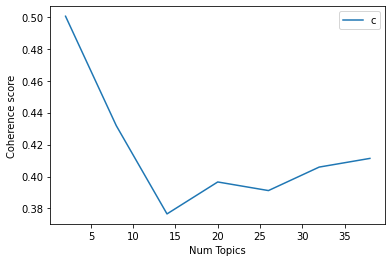

In [34]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5004
Num Topics = 8  has Coherence Value of 0.4319
Num Topics = 14  has Coherence Value of 0.3766
Num Topics = 20  has Coherence Value of 0.3966
Num Topics = 26  has Coherence Value of 0.3912
Num Topics = 32  has Coherence Value of 0.4059
Num Topics = 38  has Coherence Value of 0.4113


In [36]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"campana" + 0.036*"hacer" + 0.035*"mas" + 0.024*"rival" + '
  '0.021*"unir" + 0.020*"personar" + 0.020*"electoral" + 0.019*"menos" + '
  '0.019*"semana" + 0.018*"millón"'),
 (1,
  '0.084*"trump" + 0.056*"presidente" + 0.054*"coronavirus" + 0.032*"jueves" + '
  '0.029*"noticiar" + 0.028*"segundar" + 0.023*"anunciar" + 0.022*"dar" + '
  '0.021*"casa_blanca" + 0.020*"virtual"'),
 (2,
  '0.178*"candidato" + 0.122*"democrata" + 0.052*"republicano" + '
  '0.035*"partir" + 0.031*"vicepresidencia" + 0.024*"primero" + '
  '0.024*"miercoles" + 0.020*"presidencia" + 0.016*"presidencial" + '
  '0.014*"llegar"'),
 (3,
  '0.039*"ser" + 0.034*"estadounidense" + 0.031*"trump" + 0.027*"nuevo" + '
  '0.020*"democratas" + 0.017*"ano" + 0.015*"presidente" + 0.014*"politica" + '
  '0.014*"poner" + 0.012*"pidio"'),
 (4,
  '0.105*"elección" + 0.065*"trump" + 0.048*"votar" + 0.040*"noviembre" + '
  '0.031*"encuestar" + 0.029*"votante" + 0.026*"latino" + 0.020*"ganar" + '
  '0.016*"hispano" + 0.0

##  Finding the dominant topic in each sentence

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1500,"candidato, democrata, republicano, partir, vic...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
1,1,3.0,0.1557,"ser, estadounidense, trump, nuevo, democratas,...",Opinión El Nuevo Día | Si es relecto como pres...
2,2,7.0,0.1623,"debatir, presidencial, ﻿1, ultimar, seguir, de...",EN SU PROPIA CARA. A minutos de comenzar el DE...
3,3,6.0,0.1569,"decir, trump, poder, visitar, creer, momento, ...",¡EN SU PROPIA CASA! A minutos de que BIDEN ac...
4,4,2.0,0.1473,"candidato, democrata, republicano, partir, vic...",Junto a Alex Rodríguez participó de un convers...
5,5,2.0,0.1460,"candidato, democrata, republicano, partir, vic...",El astro boricua exhorta a votar por el candid...
6,6,2.0,0.1500,"candidato, democrata, republicano, partir, vic...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
7,7,5.0,0.1447,"presidente, discursar, hoy, noche, vicepreside...","""HABLO EN SERIO"". En plena batalla contra TRUM..."
8,8,7.0,0.1500,"debatir, presidencial, ﻿1, ultimar, seguir, de...","""ESTAMOS MURIENDO"". En pleno debate PRESIDENCI..."
9,9,3.0,0.1653,"ser, estadounidense, trump, nuevo, democratas,...",Reconoce la estadidad es la alternativa más ef...


## Find the most representative document for each topic

In [43]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.5410   
1        1.0              0.3900   
2        2.0              0.4407   
3        3.0              0.4869   
4        4.0              0.4975   

                                                                                                            Keywords  \
0                                       campana, hacer, mas, rival, unir, personar, electoral, menos, semana, millón   
1                    trump, presidente, coronavirus, jueves, noticiar, segundar, anunciar, dar, casa_blanca, virtual   
2  candidato, democrata, republicano, partir, vicepresidencia, primero, miercoles, presidencia, presidencial, llegar   
3                             ser, estadounidense, trump, nuevo, democratas, ano, presidente, politica, poner, pidio   
4                                elección, trump, votar, noviembre, encuestar, votante, latino, ganar, hispano, solo   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [42]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"candidato, democrata, republicano, partir, vicepresidencia, primero, miercoles, presidencia, presidencial, llegar",390.0,0.1314
1.0,3.0,"ser, estadounidense, trump, nuevo, democratas, ano, presidente, politica, poner, pidio",408.0,0.1375
2.0,7.0,"debatir, presidencial, ﻿1, ultimar, seguir, destinar, vivir, encontrar, temer, espanol",390.0,0.1314
3.0,6.0,"decir, trump, poder, visitar, creer, momento, ano, conocer, familia, cambiar",317.0,0.1068
4.0,2.0,"candidato, democrata, republicano, partir, vicepresidencia, primero, miercoles, presidencia, presidencial, llegar",355.0,0.1196
5.0,2.0,"candidato, democrata, republicano, partir, vicepresidencia, primero, miercoles, presidencia, presidencial, llegar",352.0,0.1186
6.0,2.0,"candidato, democrata, republicano, partir, vicepresidencia, primero, miercoles, presidencia, presidencial, llegar",279.0,0.0940
7.0,5.0,"presidente, discursar, hoy, noche, vicepresidente, candidato, tambien, evento, hablar, senador",476.0,0.1604
